# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Построим модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверим *accuracy* на тестовой выборке самостоятельно.

## Откроем и изучим файл

In [70]:
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier

In [72]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [73]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Пропуски отсутствуют.

Посмотрим на дисбаланс признаков:

In [74]:
df.groupby('is_ultra').mean()

,calls,minutes,messages,mb_used
is_ultra,,,,
0,58.463437,405.942952,33.384029,16208.466949
1,73.392893,511.224569,49.363452,19468.823228


Мы наблюдаем двухкратную разницу в количестве пользователей между тарифами в пользу `Смарт` и небольшое превосходство в среднем количестве использованных единиц всех параметров тарифа `Ультра`. У нас нет сильных перекосов.

Посмотрим на корреляцию между признаками:

In [75]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


У нас ожидаемо сильная корреляция между количеством звонков и минутами. 

## Разбьем данные на выборки

In [76]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [77]:
features_train, features_other, target_train, target_other = train_test_split(
    features, target, test_size=.4, random_state=12345)

In [78]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features_other, target_other, test_size=.5, random_state=12345)

In [79]:
print("Разрешение тренировочного датасета на входе:", features_train.shape)
print("Разрешение тестового датасета на входе:", features_test.shape)
print("Разрешение тренировочного датасета на выходе:", target_train.shape)
print("Разрешение тестового датасета на выходе:", target_test.shape)

Разрешение тренировочного датасета на входе: (1928, 4)
Разрешение тестового датасета на входе: (643, 4)
Разрешение тренировочного датасета на выходе: (1928,)
Разрешение тестового датасета на выходе: (643,)


## Исследуем модели

-   дерево решений,
-   случайный лес,
-   логистическую регрессию.

### Алгоритм классификации — _DecisionTreeClassifier_

Классификация деревом решений с использованием структуры данных `DecisionTreeClassifier` из библиотеки `scikit-learn`.

Обучим модель с параметрами по умолчанию:

In [80]:
model = DecisionTreeClassifier(random_state=12345)

model.fit(features_train, target_train)
valid_predictions = model.predict(features_valid) 

print("Accuracy на валидационной выборке:", accuracy_score(target_valid, valid_predictions))

Accuracy на валидационной выборке: 0.7309486780715396


Найдем оптимальную глубину дерева:

In [81]:
best_model_dtc = None
best_result = 0
accuracy_train = []
accuracy_valid = []

for depth in range(1, 31):
    # обучим модель
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    # получим предсказания модели
    predictions = model.predict(features_valid) 
    # посчитаем качество модели
    result = accuracy_score(target_valid, predictions) 
    if result > best_result:
        best_model_dtc = model
        best_result = result
    accuracy_train.append(accuracy_score(target_train, model.predict(features_train)))
    accuracy_valid.append(result) 
    
tree_accuracy_depth = pd.DataFrame({
    "max_depth": range(1, 31), 
    "accuracy_train": accuracy_train, 
    "accuracy_valid": accuracy_valid,})
        
print("Лучшая модель:", best_model_dtc)        
print("Accuracy лучшей модели на валидационной выборке:", best_result)

Лучшая модель: DecisionTreeClassifier(max_depth=7, random_state=12345)
Accuracy лучшей модели на валидационной выборке: 0.7993779160186625


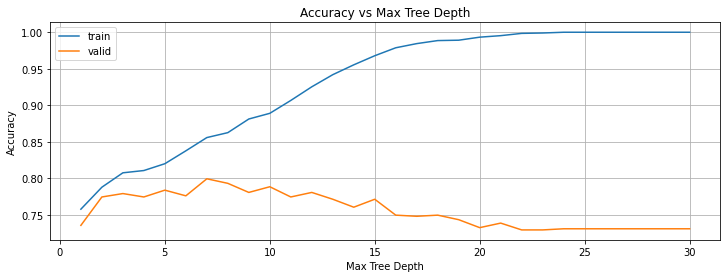

In [82]:
fig, ax = plt.subplots()

ax.plot(tree_accuracy_depth['max_depth'], tree_accuracy_depth['accuracy_train'] \
        , label = 'train')
ax.plot(tree_accuracy_depth['max_depth'], tree_accuracy_depth['accuracy_valid'] \
        , label = 'valid')
ax.legend()
ax.grid()
ax.set_title('Accuracy vs Max Tree Depth')
ax.set_xlabel('Max Tree Depth')
ax.set_ylabel('Accuracy')
fig.set_size_inches(12,4)

plt.show()

Модель переобучается после глубины дерева равным 7.

### Алгоритм классификации — _random forest_

Посмотрим на модель с гиперпараметрами по умолчанию

In [83]:
model = RandomForestClassifier()
model.fit(features_train, target_train)
result = model.score(features_valid, target_valid)

print("Модель:", model)
print("Accuracy модели на валидационной выборке:", result)

Модель: RandomForestClassifier()
Accuracy модели на валидационной выборке: 0.7791601866251944


Посмотрим на зависимость от количества деревьев:

In [84]:
best_model = None
best_result = 0
accuracy_train = []
accuracy_valid = []
for est in range(1, 61):
    # обучим модель с заданным количеством деревьев
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    accuracy_train.append(accuracy_score(target_train, model.predict(features_train)))
    accuracy_valid.append(result)
    if result > best_result:
        best_model = model
        best_result = result

rf_accuracy_est = pd.DataFrame({
    "n_estimators": range(1, 61), 
    "accuracy_train": accuracy_train, 
    "accuracy_valid": accuracy_valid,})
        
print("Наилучшая модель на валидационной выборке:", best_model)
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Наилучшая модель на валидационной выборке: RandomForestClassifier(n_estimators=48, random_state=12345)
Accuracy наилучшей модели на валидационной выборке: 0.7962674961119751


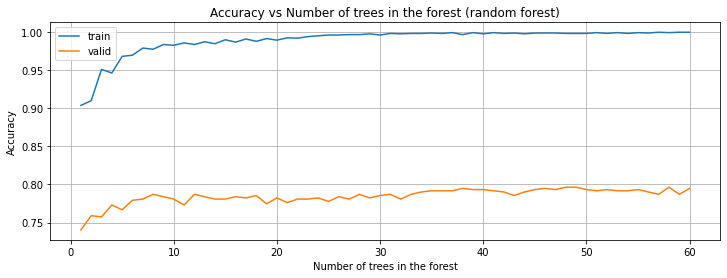

In [85]:
fig, ax = plt.subplots()

ax.plot(rf_accuracy_est['n_estimators'], rf_accuracy_est['accuracy_train'], label = 'train')
ax.plot(rf_accuracy_est['n_estimators'], rf_accuracy_est['accuracy_valid'], label = 'valid')
ax.legend()
ax.grid()
ax.set_title('Accuracy vs Number of trees in the forest (random forest)')
ax.set_xlabel('Number of trees in the forest')
ax.set_ylabel('Accuracy')
fig.set_size_inches(12,4)

plt.show()

Интересный момент: в отличие от `DecisionTreeClassifier` одиночное дерево не обучается на тестовой выборке до 100%, на валидационной выборке результаты похожи. При увеличении количества деревьев результат приближается к лучшему результату `DecisionTreeClassifier`.

Посмотрим на зависимость от максимальной глубины деревьев:

In [86]:
best_model = None
best_result = 0
accuracy_train = []
accuracy_valid = []
for depth in range(1, 31):
    model = RandomForestClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train) # обучим модель на тренировочной выборке
    result = model.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
    accuracy_train.append(accuracy_score(target_train, model.predict(features_train)))
    accuracy_valid.append(result)
    if result > best_result:
        best_model = model
        best_result = result

rf_accuracy_depth = pd.DataFrame({
    "max_depth": range(1, 31), 
    "accuracy_train": accuracy_train, 
    "accuracy_valid": accuracy_valid,})
        
print("Наилучшая модель на валидационной выборке:", best_model)
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Наилучшая модель на валидационной выборке: RandomForestClassifier(max_depth=10, random_state=12345)
Accuracy наилучшей модели на валидационной выборке: 0.8055987558320373


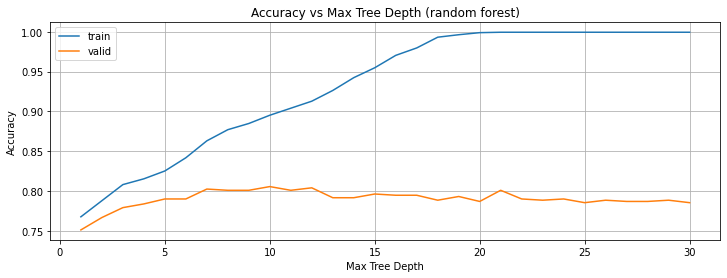

In [87]:
fig, ax = plt.subplots()

ax.plot(rf_accuracy_depth['max_depth'], rf_accuracy_depth['accuracy_train'], label = 'train')
ax.plot(rf_accuracy_depth['max_depth'], rf_accuracy_depth['accuracy_valid'], label = 'valid')

ax.legend()
ax.grid()
ax.set_title('Accuracy vs Max Tree Depth (random forest)')
ax.set_xlabel('Max Tree Depth')
ax.set_ylabel('Accuracy')
fig.set_size_inches(12,4)

plt.show()

Случайный лес имеет меньшую склонность к переобучению, но разница в точности предсказаний между обучающей и валидационной выборкой очень велика. Вероятно нам нужно больше данных чтобы повысить точность.

In [88]:
best_model = None
best_result_rfc = 0

criterions = ['gini', 'entropy']
for depth in range(1, 16):
    for estimator in range(1, 16):
        for criterion in criterions:
            model = RandomForestClassifier(random_state=12, max_depth=depth, 
                                           n_estimators=estimator, criterion=criterion)
            model.fit(features_train, target_train) 
            result = model.score(features_valid, target_valid)
            if result > best_result_rfc:
                best_model_rfc = model
                best_result_rfc = result
print("Наилучшая модель на валидационной выборке:", best_model_rfc)
print("Accuracy наилучшей модели на валидационной выборке:", best_result_rfc)

Наилучшая модель на валидационной выборке: RandomForestClassifier(max_depth=11, n_estimators=9, random_state=12)
Accuracy наилучшей модели на валидационной выборке: 0.8180404354587869


С помощью перебора в цикле модель удалось улучшить еще на 2 процентных пункта

### Алгоритм классификации — _LogisticRegression_

In [89]:
model_lr = LogisticRegression()
model_lr.fit(features_train, target_train)
print("Accuracy модели на валидационной выборке:" \
      , model_lr.score(features_valid, target_valid))

Accuracy модели на валидационной выборке: 0.6842923794712286


Сделаем перебор гиперпараметров в цикле:

In [90]:
best_model_lr = None
best_result = 0

classifier__penalty = ['l1', 'l2']
classifier__C = np.logspace(-4, 4, 20)
classifier__solver = ['liblinear', 'saga']

for penalty in classifier__penalty:
    for c in classifier__C:
        for solver in classifier__solver:
            model_lr = LogisticRegression(random_state=12345,
                                          penalty=penalty,
                                          C=c, 
                                          solver=solver)
            model_lr.fit(features_train, target_train)
            result = model_lr.score(features_valid, target_valid)
            if result > best_result:
                best_model_lr = model_lr
                best_result = result
        
print("Наилучшая модель на валидационной выборке:", best_model_lr)
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Наилучшая модель на валидационной выборке: LogisticRegression(C=0.615848211066026, penalty='l1', random_state=12345,
                   solver='liblinear')
Accuracy наилучшей модели на валидационной выборке: 0.7418351477449455


Нам удалось значительно улучшить модель (на 6%) по сравнению с моделью регрессии с базовыми гиперпараметрами.

### Вывод: 
Лучшая модель - случайный лес.

## Проверим модель на тестовой выборке

In [91]:
best_model_rfc.score(features_test, target_test)

0.7978227060653188

### Проведем дополнительное исследование

Обучим лучшие модели на объединенных обучающих и валидационных данных

In [92]:
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

In [93]:
features_train.shape

(1928, 4)

In [94]:
features_train_valid.shape

(2571, 4)

Случайный лес:

In [95]:
model = RandomForestClassifier(criterion='entropy', 
                               max_depth=13, 
                               n_estimators=6,
                               random_state=1)
model.fit(features_train_valid, target_train_valid) 
model.score(features_test, target_test)

0.7916018662519441

Результат немного ухудшился.

Логистическая регрессия:

In [96]:
best_model_lr.score(features_test, target_test)

0.7573872472783826

In [97]:
best_model_lr_valid = LogisticRegression(C=4.281332398719396, 
                                         penalty='l1', 
                                         random_state=1,
                                         solver='liblinear')

In [98]:
best_model_lr_valid.fit(features_train_valid, target_train_valid)
best_model_lr_valid.score(features_test, target_test)

0.7511664074650077

Результат немного ухудшился.

Решающее дерево:

In [99]:
best_model_dtc.score(features_test, target_test)

0.7822706065318819

In [100]:
best_model_dtc_valid = DecisionTreeClassifier(max_depth=7, random_state=1)
best_model_dtc_valid.fit(features_train_valid, target_train_valid)
best_model_dtc_valid.score(features_test, target_test)

0.7916018662519441

Результат улучшился на 1% и полностью идентичен случайному лесу.

Можно объяснить такую нестабильность результатов очень маленькой выборкой.

### Вывод:
дерево решений и случайный лес ухудшили результаты на тестовой выборке, а логистическая регрессия даже превзошла результаты на обучающей выборке.Нам нужен значительно больший объем данных для повышения качества предсказаний.

## Проверим модели на адекватность

In [101]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)

dummy_clf.score(features_valid, target_valid)

0.6842923794712286

Полученные модели имеют более высокое значение accuracy (доля правильных ответов), чем у Dummy- алгоритма.